In [ ]:

import itertools
import collections
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import multidict as multidict
from wordcloud import WordCloud
from nltk import bigrams
import networkx as nx


url = 'https://raw.githubusercontent.com/hackforla/data-science/160-survey-repo-labels/labels-survey/output.csv' # GitHub URL to .csv data
plt.rcParams["figure.figsize"] = (24,5.5)


data = pd.read_csv(url)  # Load data from GitHub into pandas
data['ClosedAt']= pd.to_datetime(data['ClosedAt']) # Converting into datetime
data['CreatedAt']= pd.to_datetime(data['CreatedAt']) # Converting into datetime
data['DaysToClosure'] = (data['ClosedAt'] - data['CreatedAt']).dt.days # Converting into datetime
data['DaysToClosure'] = data['DaysToClosure'].replace(0, np.NaN)
data['IssueNbr'] = data['IssueNbr'].astype(str) 
data['UniqueKey'] = data['IssueNbr'] + data['Repository'] + data['Organization'] # Generating a unique id for issues
data['haslabel'] = np.where(data['LabelName'].isnull(), 'Without Label', 'With Label(s)') # Flagging issues with or without labels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Three Research Questions:

**1.- How is the usage of labels in HfLA?**

1a - What percentage of issues are labeled?

1b - How many labels are used?

1c - How many labels are used per project?

1d - What are the most popular ones?

**2.- How does the usage of labels impact the resolution of issues**?

**3.- Cluster analysis**

In [ ]:
fig = px.pie(data.groupby('haslabel').UniqueKey.nunique(),values='UniqueKey',names=['Without Label(s)','With Label(s)'], title='Label Usage in HfLA Issues - GitHub')
fig.show()

AxesSubplot(0.125,0.125;0.775x0.755)


NameError: ignored

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9203 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9203 missing from current font.



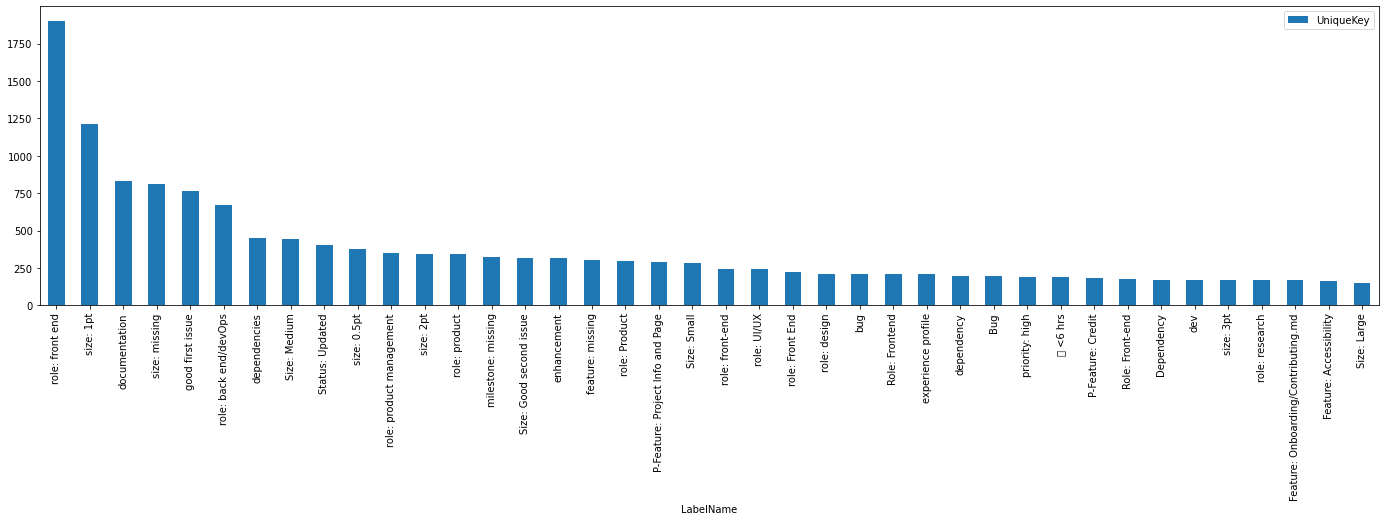

In [ ]:
labelname_aggr = data.groupby(['LabelName'], as_index=False).UniqueKey.nunique() #Aggregating data by label name and counting # unique issues.
print(labelname_aggr.sort_values('UniqueKey', ascending=False).head(40).plot.bar(x='LabelName'))
plt.title('Top 40 used labels in issues - HfLA',**hfont)
plt.xlabel('Label Name', **hfont)
plt.show()
print(labelname_aggr['LabelName'].count())

NameError: ignored

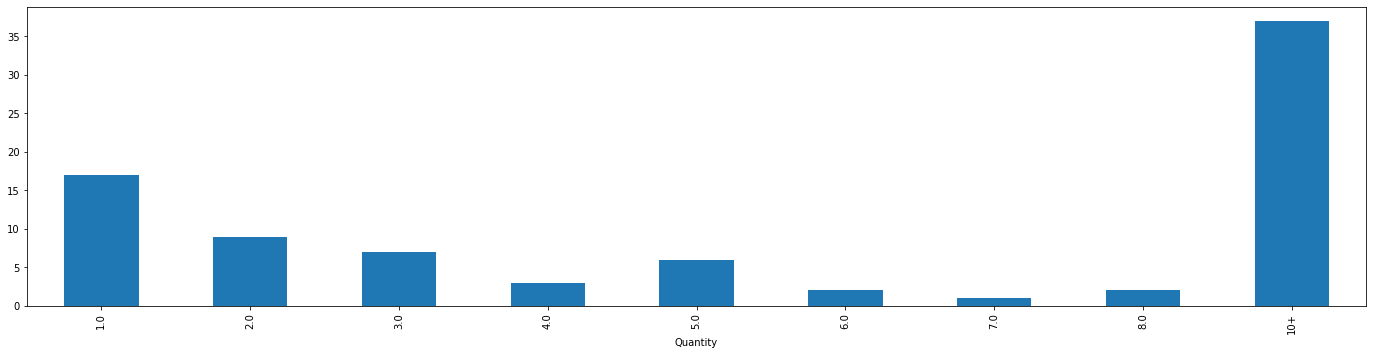

In [ ]:


#Grouping data by repository/project and unique labels
repo_aggr2 = data.groupby(['Repository'], as_index=False).nunique() 

# Binning of the data based on a condition
repo_aggr2.loc[repo_aggr2.LabelName == 1, 'Quantity'] = 1
repo_aggr2.loc[repo_aggr2.LabelName == 2, 'Quantity'] = 2
repo_aggr2.loc[repo_aggr2.LabelName == 3, 'Quantity'] = 3
repo_aggr2.loc[repo_aggr2.LabelName == 4, 'Quantity'] = 4
repo_aggr2.loc[repo_aggr2.LabelName == 5, 'Quantity'] = 5
repo_aggr2.loc[repo_aggr2.LabelName == 6, 'Quantity'] = 6
repo_aggr2.loc[repo_aggr2.LabelName == 7, 'Quantity'] = 7
repo_aggr2.loc[repo_aggr2.LabelName == 8, 'Quantity'] = 8
repo_aggr2.loc[repo_aggr2.LabelName == 9, 'Quantity'] = 9
repo_aggr2.loc[repo_aggr2.LabelName >= 10, 'Quantity'] = '10+'

#Grouping data on each bin and counting the number of repositories per bin
repo_aggr3 = repo_aggr2.groupby('Quantity').count()

#Plotting
repo_aggr3['Repository'].plot.bar(x='Repository')
plt.title('Number of Unique Labels Used per Project (Repository)',**hfont)
plt.xlabel('# Unique Labels', **hfont)
plt.ylabel('# Projects', **hfont)
plt.show()


In [ ]:
df = data.groupby('Repository') \
       .agg({'LabelName':'nunique', 'DaysToClosure':'mean'}) \
       .rename(columns={'LabelName':'count','DaysToClosure':'mean_days_closure'}) \
       .reset_index()
df

,Repository,count,mean_days_closure
0,.github,1,1.000000
1,.github-automations,1,35.600000
2,311-data,70,110.904712
3,311-report,2,26.714286
4,Architecture,0,NaN
...,...,...,...
113,undebate,0,NaN
114,website,114,52.049543
115,website-redesign,2,97.720000
116,workshop-wednesdays,2,NaN


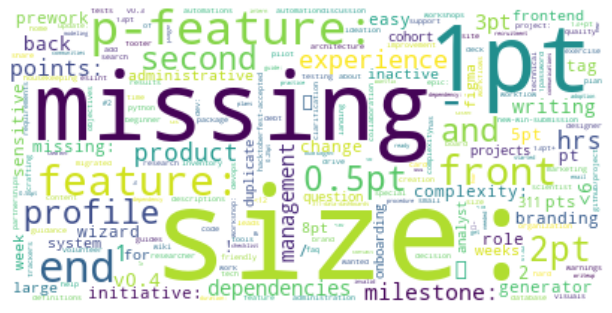

In [ ]:
def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

def makeImage(text):
    #alice_mask = np.array(Image.open("alice_mask.png"))

    wc = WordCloud(background_color="white", max_words=1000)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()



l = data['LabelName'][data['LabelName'].notnull()]
#print(l)
l = [' '.join(l)]

makeImage(getFrequencyDictForText(str(l)))

In [ ]:
#Dropping issues with no labels
key_aggr_labels = data[['UniqueKey','LabelName']].dropna()
#Aggregating the data by unique ID and creating a field with the all the issue's labels
key_aggr_labels = key_aggr_labels.groupby(['UniqueKey'])['LabelName'].apply(list)
# Getting label bigrams
key_aggr_labels = key_aggr_labels.reset_index()
label_bigram = [list(bigrams(label)) for label in key_aggr_labels['LabelName']]
# Flattening the bigrams
bigrams = list(itertools.chain(*label_bigram))
# Counting most popular label bigrams
bigram_counts = collections.Counter(bigrams)
# Creating a dataframe of the top 20 label co-occurrences
labels_bigram_df = pd.DataFrame(bigram_counts.most_common(20))
print(labels_bigram_df)


                                                    0    1
0            (role: front end, role: back end/devOps)  406
1                 (good first issue, role: front end)  376
2                     (role: front end, Size: Medium)  274
3              (feature: missing, milestone: missing)  129
4          (role: front end, Size: Good second issue)  128
5   (role: front end, P-Feature: Project Info and ...  127
6                          (role: Product, size: 1pt)  117
7   (role: back end/devOps, P-Feature: Project Inf...  108
8                    (P-Feature: Credit, size: 0.5pt)  105
9               (milestone: missing, points: missing)  101
10              (role: back end/devOps, Size: Medium)   97
11  (P-Feature: Project Info and Page, Size: Good ...   90
12         (role: back end/devOps, P-Feature: Credit)   87
13                    (Size: Medium, Status: Updated)   85
14                  (size: missing, feature: missing)   77
15                         (Size: Small, size: 0.5pt)   

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 128100 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9203 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 128100 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9203 missing from current font.



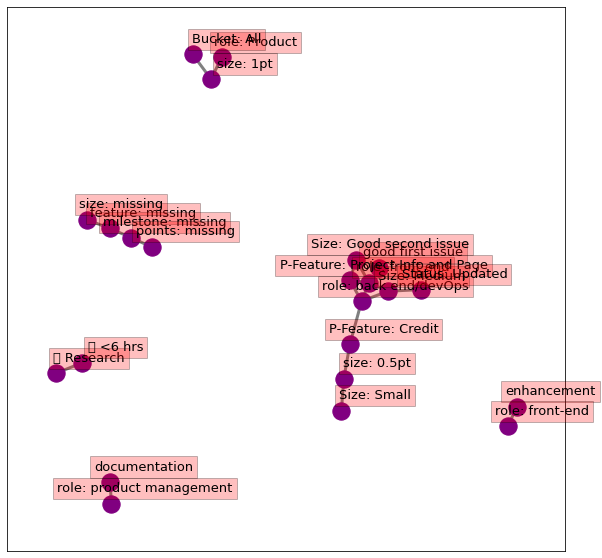

In [ ]:
labels_bigram_df=labels_bigram_df.rename(columns={0: "bigram", 1: "count"})
d = labels_bigram_df.set_index("bigram").T.to_dict("records")
# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


fig, ax = plt.subplots(figsize=(10, 10))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=11,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels=False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0] + .135, value[1] + .045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

In [ ]:
print((repo_aggr2.groupby('Quantity'))['DaysToClosure'].mean())

Quantity
1.0     2.588235
2.0     3.666667
3.0     1.428571
4.0    14.333333
5.0     6.833333
6.0     4.500000
7.0    15.000000
8.0    10.000000
10+    70.621622
Name: DaysToClosure, dtype: float64
